# LaLonde Empirical Application

This notebook implements the empirical illustration in **Section 6** of the paper.
We apply the $\hat{\kappa}_{\text{oof}}$ diagnostic to the LaLonde (1986) job training
dataset, comparing DML estimates across experimental (NSW) and observational (NSW-PSID)
samples.

**Outputs:** Figure 3 (forest plot) and Table 8 (baseline estimates by learner).

## 1. Setup

In [ ]:
# Standard imports
import sys
import warnings
from pathlib import Path

warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy import stats

# Add project root to path
sys.path.insert(0, '..')

# Import from src modules
from src.data import (
    load_lalonde, 
    get_sample_summary,
    EXPERIMENTAL_BENCHMARK,
)
from src.learners import get_learner, LALONDE_LEARNERS
from src.dml import DMLEstimator
from src.tuning import tune_rf_for_data

# Matplotlib settings (matching Monte Carlo figures)
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': ['Times New Roman', 'DejaVu Serif', 'serif'],
    'font.size': 11,
    'mathtext.fontset': 'stix',
    'figure.figsize': (10, 6),
    'figure.dpi': 150,
    'figure.facecolor': 'white',
    'axes.labelsize': 11,
    'axes.titlesize': 12,
    'axes.linewidth': 0.8,
    'legend.fontsize': 9,
    'legend.framealpha': 1.0,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
    'savefig.facecolor': 'white',
})

# Output paths
RESULTS_DIR = Path('../results')
RESULTS_DIR.mkdir(exist_ok=True)

# Random seed for reproducibility
RANDOM_STATE = 42

print("Setup complete.")
print("=" * 60)
print("=" * 60)
print("LALONDE APPLICATION: κ Diagnostic in Canonical Data")
print("=" * 60)
print(f"Experimental Benchmark ATE: ${EXPERIMENTAL_BENCHMARK:,}")

Setup complete.
LALONDE APPLICATION: κ Diagnostic in Canonical Data
Experimental Benchmark ATE: $1,794


## 2. Data

**Experimental sample:** NSW treated vs. NSW randomized control (N ≈ 445).
**Observational sample:** NSW treated vs. PSID comparison (N ≈ 2,675).

In [ ]:
# Load experimental data (NSW treated vs NSW control)
y_exp, d_exp, X_exp = load_lalonde(mode='experimental', standardize=True)
summary_exp = get_sample_summary(y_exp, d_exp, X_exp)
print(f"\nExperimental Sample: N={len(y_exp)}")
print(f"  Treated: {int(d_exp.sum())}, Control: {int(len(d_exp) - d_exp.sum())}")
print(f"  Naive ATE: ${summary_exp['naive_ate']:,.0f}")

Loading LaLonde data (mode='experimental')...
  Sample: Experimental (NSW)
  N = 445 (Treated: 185, Control: 260)
  Covariates: ['age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75']
  Standardized: True

Experimental Sample: N=445
  Treated: 185, Control: 260
  Naive ATE: $1,794


In [ ]:
# Load observational data (NSW treated vs PSID control)
y_obs, d_obs, X_obs = load_lalonde(mode='observational', standardize=True)
summary_obs = get_sample_summary(y_obs, d_obs, X_obs)
print(f"\nObservational Sample: N={len(y_obs)}")
print(f"  Treated: {int(d_obs.sum())}, Control: {int(len(d_obs) - d_obs.sum())}")
print(f"  Naive ATE: ${summary_obs['naive_ate']:,.0f}")
print("\n⚠️ Note: The observational naive ATE is negative due to selection bias!")

Loading LaLonde data (mode='observational')...
  Sample: Observational (NSW-PSID)
  N = 2,675 (Treated: 185, Control: 2490)
  Covariates: ['age', 'education', 'black', 'hispanic', 'married', 'nodegree', 're74', 're75']
  Standardized: True

Observational Sample: N=2675
  Treated: 185, Control: 2490
  Naive ATE: $-15,205

⚠️ Note: The observational naive ATE is negative due to selection bias!


## 3. RF Hyperparameter Tuning

In [ ]:
print("\nTuning RF hyperparameters for LaLonde data...")

print("  Tuning on Experimental sample...", end=" ")
rf_params_exp = tune_rf_for_data(X_exp, d_exp, random_state=RANDOM_STATE)
print(f"Done. Best: {rf_params_exp}")

print("  Tuning on Observational sample...", end=" ")
rf_params_obs = tune_rf_for_data(X_obs, d_obs, random_state=RANDOM_STATE)
print(f"Done. Best: {rf_params_obs}")


Tuning RF hyperparameters for LaLonde data...
  Tuning on Experimental sample... Done. Best: {'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 10}
  Tuning on Observational sample... Done. Best: {'min_samples_leaf': 10, 'max_features': 'sqrt', 'max_depth': 10}


## 4. DML Estimation

In [ ]:
# Learners to evaluate
LEARNERS = LALONDE_LEARNERS
print(f"\nLearners for comparison: {LEARNERS}")

# DML settings
K_FOLDS = 5
N_REPEATS = 3


Learners for comparison: ['OLS', 'Lasso', 'Ridge', 'RF_Tuned', 'GBM', 'MLP']


In [ ]:
def run_dml_for_sample(y, d, X, sample_name, learners=LEARNERS, rf_params=None):
    """Run DML with multiple learners on a single sample."""
    results = []
    
    for learner_name in tqdm(learners, desc=f"{sample_name}"):
        params = rf_params if learner_name.upper() == 'RF_TUNED' else None
        learner_m = get_learner(learner_name, random_state=RANDOM_STATE, params=params)
        learner_l = get_learner(learner_name, random_state=RANDOM_STATE, params=params)
        
        dml = DMLEstimator(
            learner_m=learner_m,
            learner_l=learner_l,
            K=K_FOLDS,
            n_repeats=N_REPEATS,
            random_state=RANDOM_STATE,
        )
        
        result = dml.fit(Y=y, D=d, X=X)
        
        results.append({
            'Sample': sample_name,
            'Learner': learner_name,
            'Estimate': result.theta_hat,
            'SE': result.se,
            'CI_Lower': result.ci_lower,
            'CI_Upper': result.ci_upper,
            'Kappa': result.kappa,
            'N': len(y),
        })
    
    return pd.DataFrame(results)

In [ ]:
# Run DML on experimental sample
print("\nRunning DML on Experimental Sample...")
df_exp = run_dml_for_sample(y_exp, d_exp, X_exp, 'Experimental', rf_params=rf_params_exp)
print("\nExperimental Results:")
print(df_exp.round(2).to_string())


Running DML on Experimental Sample...


Experimental: 100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Experimental Results:
         Sample   Learner  Estimate      SE  CI_Lower  CI_Upper  Kappa    N
0  Experimental       OLS   1598.36  667.74    289.58   2907.13    1.0  445
1  Experimental     Lasso   1700.40  673.41    380.52   3020.29    1.0  445
2  Experimental     Ridge   1615.36  666.08    309.83   2920.88    1.0  445
3  Experimental  RF_Tuned   1564.01  650.70    288.63   2839.39    1.0  445
4  Experimental       GBM   1809.92  662.49    511.44   3108.41    1.0  445
5  Experimental       MLP   1019.08  847.38   -641.79   2679.95    1.0  445


In [ ]:
# Run DML on observational sample  
print("\nRunning DML on Observational Sample...")
df_obs = run_dml_for_sample(y_obs, d_obs, X_obs, 'Observational', rf_params=rf_params_obs)
print("\nObservational Results:")
print(df_obs.round(2).to_string())


Running DML on Observational Sample...


Observational: 100%|██████████| 6/6 [00:36<00:00,  6.02s/it]


Observational Results:
          Sample   Learner  Estimate      SE  CI_Lower  CI_Upper  Kappa     N
0  Observational       OLS    699.90  785.35   -839.39   2239.20   1.41  2675
1  Observational     Lasso    189.78  633.98  -1052.81   1432.38   1.01  2675
2  Observational     Ridge    699.21  783.91   -837.26   2235.68   1.41  2675
3  Observational  RF_Tuned   -803.06  969.07  -2702.44   1096.32   2.57  2675
4  Observational       GBM  -1158.06  956.83  -3033.45    717.32   2.62  2675
5  Observational       MLP   -775.94  938.77  -2615.94   1064.05   2.53  2675


In [ ]:
# Combine results
df_baseline = pd.concat([df_exp, df_obs], ignore_index=True)

# Save to CSV
baseline_path = RESULTS_DIR / 'lalonde_baseline_results.csv'
df_baseline.to_csv(baseline_path, index=False)
print(f"\nBaseline results saved to: {baseline_path}")


Baseline results saved to: ../results/lalonde_baseline_results.csv


## 5. Conditioning Diagnostic

Reports $\hat{\kappa}_{\text{oof}}$ for each sample. Per **Theorem 3.11**, higher $\kappa$
implies greater sensitivity to nuisance estimation error.

In [ ]:
print("\n" + "=" * 60)
print("CONDITIONING ANALYSIS")
print("=" * 60)

for sample_name, df_sample in [('Experimental', df_exp), ('Observational', df_obs)]:
    mean_kappa = df_sample['Kappa'].mean()
    n = df_sample['N'].iloc[0]
    
    print(f"\n{sample_name} Sample:")
    print(f"  Mean κ = {mean_kappa:.2f}")
    print(f"  N = {n:,}")

# Estimate dispersion
exp_range = df_exp['Estimate'].max() - df_exp['Estimate'].min()
obs_range = df_obs['Estimate'].max() - df_obs['Estimate'].min()
print(f"\n\nEstimate Dispersion Across Learners:")
print(f"  Experimental: ${exp_range:,.0f}")
print(f"  Observational: ${obs_range:,.0f}")
print(f"  Ratio: {obs_range/exp_range:.1f}x more dispersion in observational sample")


CONDITIONING ANALYSIS

Experimental Sample:
  Mean κ = 1.00
  N = 445

Observational Sample:
  Mean κ = 1.92
  N = 2,675


Estimate Dispersion Across Learners:
  Experimental: $791
  Observational: $1,858
  Ratio: 2.3x more dispersion in observational sample


## 6. Forest Plot (Figure 3)

Compares DML estimates across learners. The experimental sample ($\hat{\kappa} \approx 1$)
shows tight clustering around the benchmark; the observational sample ($\hat{\kappa} > 2$)
exhibits greater learner disagreement, consistent with higher conditioning.

**→ Produces Figure 3 in the paper.**


✓ Saved: ../results/lalonde_forest_plot.pdf


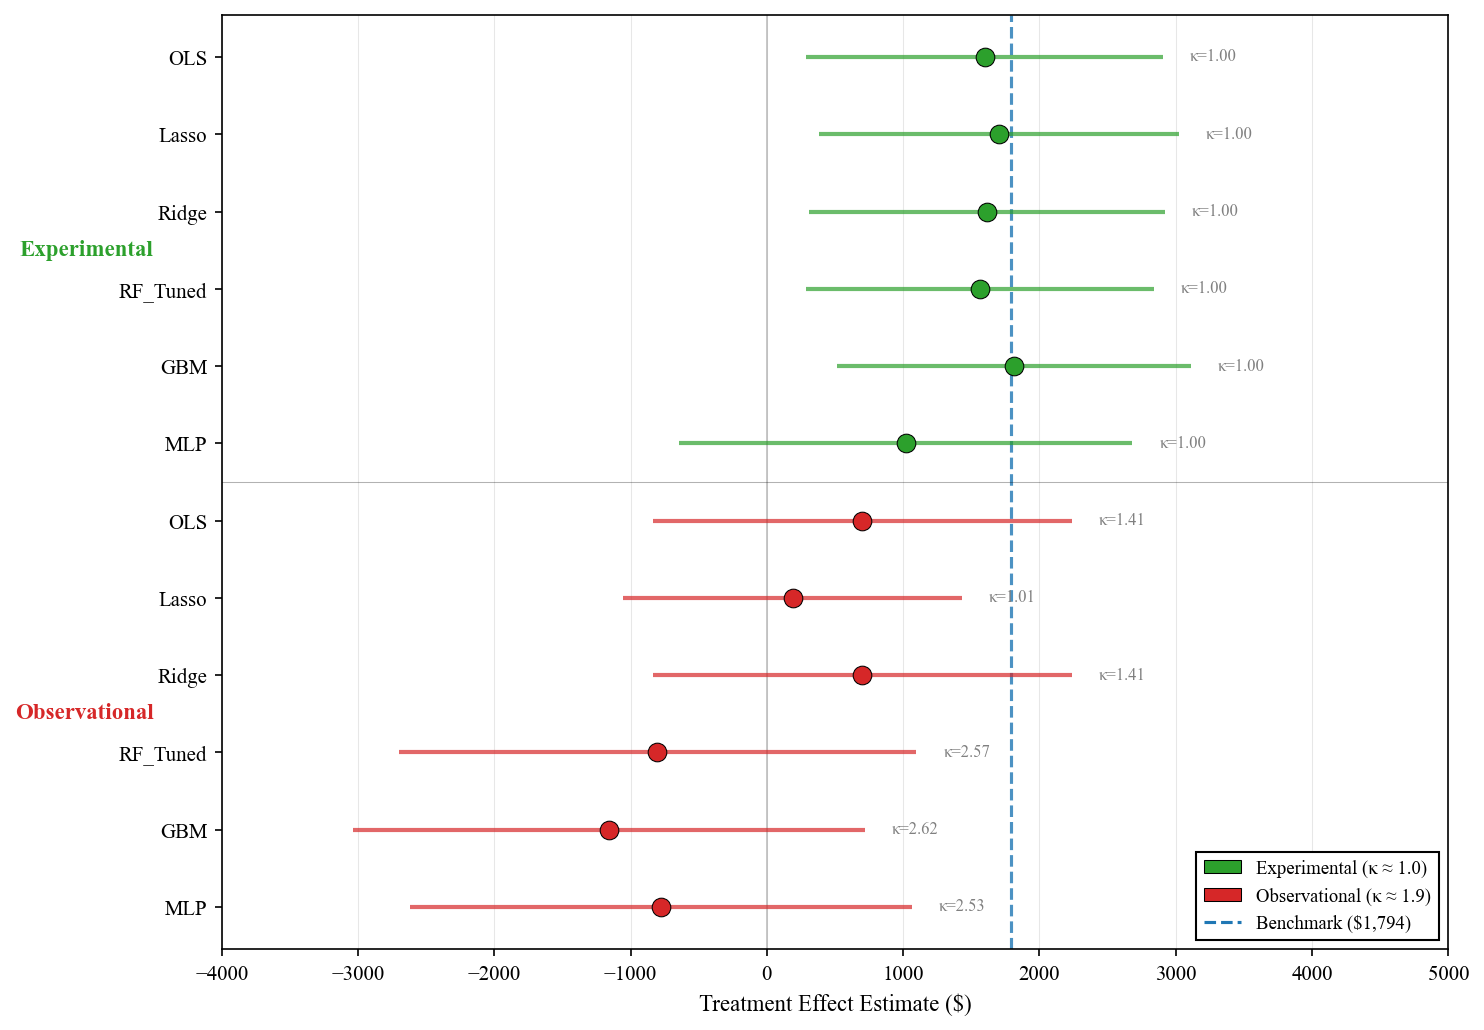

In [ ]:
# =============================================================================
# FOREST PLOT 
# =============================================================================

from matplotlib.patches import Patch
from matplotlib.lines import Line2D

COLORS = {
    'Experimental': '#2ca02c',     # Muted green
    'Observational': '#d62728',    # Muted red
    'benchmark': '#1f77b4',        # Muted blue
}

fig, ax = plt.subplots(figsize=(10, 7))
fig.patch.set_facecolor('white')

# Prepare data - order by sample then learner
df_plot = df_baseline.copy()
df_plot['y_pos'] = range(len(df_plot))

# Add separator between samples
n_exp = len(df_exp)

# Plot confidence intervals and point estimates
for idx, row in df_plot.iterrows():
    color = COLORS[row['Sample']]
    y = row['y_pos']
    
    # CI line
    ax.hlines(y=y, xmin=row['CI_Lower'], xmax=row['CI_Upper'], 
              color=color, linewidth=2, alpha=0.7)
    
    # Point estimate marker
    ax.scatter(row['Estimate'], y, color=color, s=80, zorder=5, 
               edgecolors='black', linewidth=0.5, marker='o')
    
    # κ annotation (right side)
    ax.annotate(f"κ={row['Kappa']:.2f}", 
                xy=(row['CI_Upper'] + 200, y),
                fontsize=8, color='gray', va='center')

# Experimental benchmark reference line
ax.axvline(x=EXPERIMENTAL_BENCHMARK, color=COLORS['benchmark'], 
           linestyle='--', linewidth=1.5, alpha=0.8, zorder=1)

# Zero reference line  
ax.axvline(x=0, color='gray', linestyle='-', linewidth=0.8, alpha=0.5, zorder=0)

# Horizontal separator between samples
ax.axhline(y=n_exp - 0.5, color='black', linestyle='-', linewidth=0.5, alpha=0.3)

# Y-axis labels
y_labels = [f"{row['Learner']}" for _, row in df_plot.iterrows()]
ax.set_yticks(df_plot['y_pos'])
ax.set_yticklabels(y_labels, fontsize=10)

# Add sample group labels on left
ax.text(-4500, (n_exp-1)/2, 'Experimental', fontsize=11, fontweight='bold',
        va='center', ha='right', color=COLORS['Experimental'])
ax.text(-4500, n_exp + (len(df_obs)-1)/2, 'Observational', fontsize=11, fontweight='bold',
        va='center', ha='right', color=COLORS['Observational'])

# Axis formatting
ax.set_xlabel('Treatment Effect Estimate ($)', fontsize=11)
ax.set_xlim(-4000, 5000)
ax.grid(True, alpha=0.3, axis='x', linestyle='-', linewidth=0.5)
ax.invert_yaxis()
ax.tick_params(axis='both', which='major', labelsize=10)

# Simple square legend box
legend_elements = [
    Patch(facecolor=COLORS['Experimental'], edgecolor='black', linewidth=0.5,
          label=f'Experimental (κ ≈ {df_exp["Kappa"].mean():.1f})'),
    Patch(facecolor=COLORS['Observational'], edgecolor='black', linewidth=0.5,
          label=f'Observational (κ ≈ {df_obs["Kappa"].mean():.1f})'),
    Line2D([0], [0], color=COLORS['benchmark'], linestyle='--', linewidth=1.5,
           label=f'Benchmark (${EXPERIMENTAL_BENCHMARK:,})'),
]
ax.legend(handles=legend_elements, loc='lower right', fontsize=9, 
          framealpha=1.0, edgecolor='black', fancybox=False)

plt.tight_layout()
plt.savefig(RESULTS_DIR / 'lalonde_forest_plot.pdf', dpi=300, bbox_inches='tight', facecolor='white')
plt.savefig(RESULTS_DIR / 'lalonde_forest_plot.png', dpi=300, bbox_inches='tight', facecolor='white')
print(f"\n✓ Saved: {RESULTS_DIR / 'lalonde_forest_plot.pdf'}")
plt.show()

## 7. Summary (Table 8)

Reports DML estimates, standard errors, and $\hat{\kappa}_{\text{oof}}$ by sample and learner.

**→ Produces Table 8 in the paper (Appendix).**

In [ ]:
print("\n" + "=" * 80)
print("SUMMARY: LALONDE DIAGNOSTIC ANALYSIS")
print("=" * 80)

# Key metrics
kappa_exp_mean = df_exp['Kappa'].mean()
kappa_obs_mean = df_obs['Kappa'].mean()
n_exp = df_exp['N'].iloc[0]
n_obs = df_obs['N'].iloc[0]

print(f"\n{'Metric':<25} {'Experimental':>15} {'Observational':>15}")
print("-" * 55)
print(f"{'N (sample size)':<25} {n_exp:>15,} {n_obs:>15,}")
print(f"{'Mean κ':<25} {kappa_exp_mean:>15.2f} {kappa_obs_mean:>15.2f}")
print(f"{'Estimate dispersion':<25} ${exp_range:>13,.0f} ${obs_range:>13,.0f}")

print(f"\n\n→ Dispersion ratio (Obs/Exp): {obs_range/exp_range:.1f}x")
print(f"→ Higher κ in observational sample corresponds to greater learner disagreement")


SUMMARY: LALONDE DIAGNOSTIC ANALYSIS

Metric                       Experimental   Observational
-------------------------------------------------------
N (sample size)                       445           2,675
Mean κ                               1.00            1.92
Estimate dispersion       $          791 $        1,858


→ Dispersion ratio (Obs/Exp): 2.3x
→ Higher κ in observational sample corresponds to greater learner disagreement


In [ ]:
# Save final results
df_baseline.to_csv(RESULTS_DIR / 'lalonde_results.csv', index=False)

print("\n" + "=" * 60)
print("LALONDE ANALYSIS COMPLETE")
print("=" * 60)
print(f"\nResults saved to: {RESULTS_DIR}")
print("  - lalonde_results.csv")
print("  - lalonde_baseline_results.csv")
print("  - lalonde_forest_plot.pdf / .png")


LALONDE ANALYSIS COMPLETE

Results saved to: ../results
  - lalonde_results.csv
  - lalonde_baseline_results.csv
  - lalonde_forest_plot.pdf / .png
